# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
When we drive, we use our eyes to decide where to go. The lines on the road that show us where the lanes are act as our constant reference for where to steer the vehicle. Naturally, one of the first things we would like to do in developing a self-driving car is to automatically detect lane lines using an algorithm. [1]

The goal is to detect lane lines in images using Python and OpenCV.

## Import Packages

In [1]:
#importing some useful packages
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Test Image

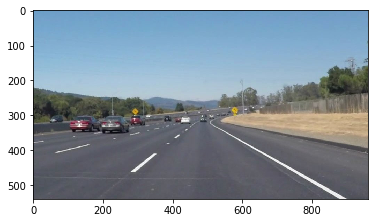

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('test_images/solidYellowCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
plt.imshow(image)

# Solution Pipeline

## Step 1 - Convert To Grayscale

In [3]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

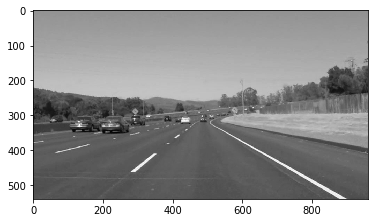

In [4]:
gray = grayscale(image)
plt.imshow(gray, cmap='gray')

## Step 2 - Apply Gaussian noise kernal

In [5]:
def gaussian(image):
    kernel_size = 5
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [6]:
blur_gray = gaussian(gray)

## Step 3 - Apply Canny edge detection

In [7]:
def canny(image):
    low_threshold = 50
    high_threshold = 150
    return cv2.Canny(image, low_threshold, high_threshold)

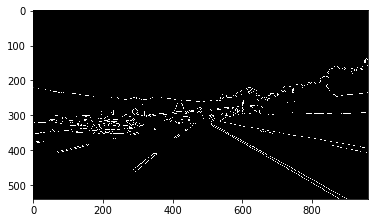

In [8]:
edges = canny(blur_gray)
plt.imshow(edges, cmap='gray')

## Step 4 - Apply Region masking

In [9]:
def mask(image):
    # Create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(image)
    # Define a four sided polygon to mask
    imshape = image.shape
    if len(imshape) > 2:
        channel_count = imshape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    vertices = np.array([[(0,imshape[0]),(500, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    return cv2.bitwise_and(image, mask)

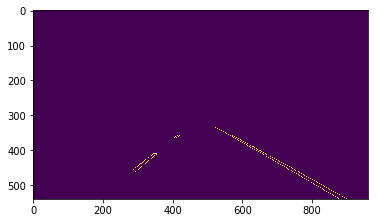

In [10]:
masked_edges = mask(edges)
plt.imshow(masked_edges)

## Step 5 - Apply Hough Transform

In [11]:
def hough(image):
    rho = 2                         # distance resolution in pixels of the Hough grid
    theta = np.pi/180               # angular resolution in radians of the Hough grid
    threshold = 19                  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 24            # minimum number of pixels making up a line
    max_line_gap = 20               # maximum gap in pixels between connectable line segments
    # Run Hough on edge detected image. Output is an array containing endpoints of detected line segments.
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

In [12]:
lines = hough(masked_edges)
print(*lines)

[[580 362 898 538]] [[535 341 877 538]] [[389 382 420 356]] [[302 443 347 410]] [[290 463 353 412]] [[576 360 645 399]] [[386 383 418 360]] [[383 381 411 359]] [[295 461 352 412]] [[613 385 781 482]] [[816 504 876 538]] [[322 427 346 410]] [[614 381 897 538]] [[281 462 317 431]]


## Step 6 - Find the left and right lanes

In [13]:
def draw_lanes(lines, image):
    
    lane_image = np.copy(image)*0 #creating a blank to draw lines on
    lane_color = (0,0,255)
    lane_thickness = 10
    
    left_slopes = []
    left_intercepts = []
    
    right_slopes = []
    right_intercepts = []
    
    y_max = image.shape[0]
    y_min = lane_image.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m, b = np.polyfit((x1, x2), (y1, y2), 1)
            y_min = min(y_min, y1, y2)
            if(m > 0):
                left_slopes.append(m)
                left_intercepts.append(b)
            if(m < 0):
                right_slopes.append(m)
                right_intercepts.append(b)
    
    if len(left_slopes) > 0: 
        # Draw the left lane
        left_slope = np.median(left_slopes)
        left_intercept = np.median(left_intercepts)
        left_x_min = int((y_min-left_intercept)/left_slope)
        left_x_max = int((y_max-left_intercept)/left_slope)
        cv2.line(lane_image, (left_x_min, y_min), (left_x_max, y_max), lane_color, lane_thickness)
    if len(right_slopes) > 0:
        # Draw the right lane
        right_slope = np.median(right_slopes)
        right_intercept = np.median(right_intercepts)
        right_x_min = int((y_min-right_intercept)/right_slope)
        right_x_max = int((y_max-right_intercept)/right_slope)
        cv2.line(lane_image, (right_x_min, y_min), (right_x_max, y_max), lane_color, lane_thickness)
    
    return cv2.addWeighted(image, 0.8, lane_image, 1, 0)

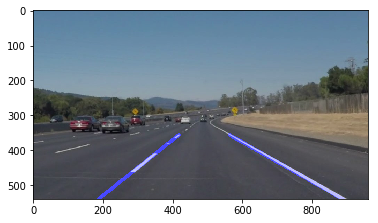

In [14]:
lanes = draw_lanes(lines, image)
plt.imshow(lanes)

# Final Pipeline

In [15]:
def pipeline(image):
    gray = grayscale(image)
    filtered = gaussian(gray)
    edges = canny(filtered)
    masked = mask(edges)
    lines = hough(masked)
    
    return draw_lanes(lines, image)

# Test on Images

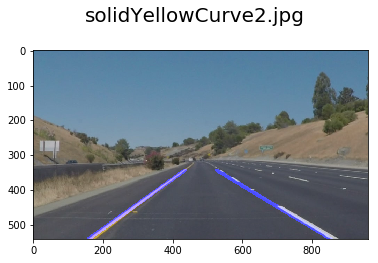

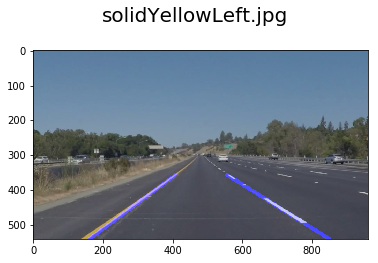

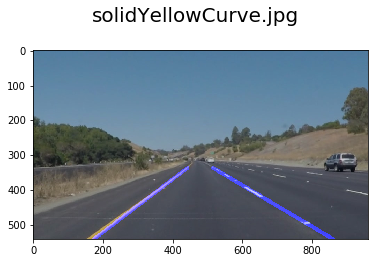

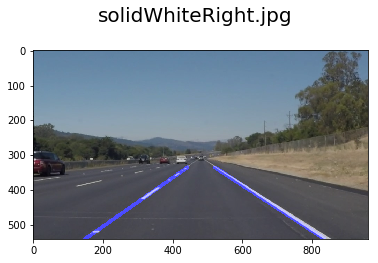

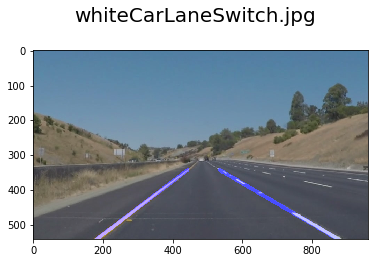

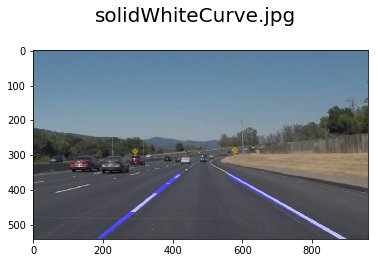

In [16]:
import os

test_images = os.listdir("test_images/")

if not os.path.isdir("results"):
    os.mkdir("results")

for i in range(0, len(test_images)):
    # Read image
    img = mpimg.imread(os.path.join("test_images", test_images[i]))
    # Run the pipeline
    img_out = pipeline(img)
    # Save output
    mpimg.imsave(os.path.join("results", test_images[i]), img_out)
    # Show output
    plt.figure()
    plt.suptitle(test_images[i], fontsize=20)
    plt.imshow(img_out)

# Run on a movie

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 76.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 9.5 s, sys: 232 ms, total: 9.73 s
Wall time: 3.12 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [21]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:08<00:00, 76.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 28.1 s, sys: 652 ms, total: 28.7 s
Wall time: 9.12 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [25]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:10<00:00, 24.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 20.8 s, sys: 516 ms, total: 21.3 s
Wall time: 10.6 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))